In [1]:
# 
# wget --recursive --convert-links --page-requisites --no-parent www.mctb.org
import glob, json
jsons=glob.glob('www.mctb.org/wp-json/wp/v2/pages/*')
import rich, rich.pretty
import dataclasses
import typing
from lxml import etree
import lxml.html
import html
import networkx as nx

DG=nx.DiGraph()

@dataclasses.dataclass
class Chapter(object):
    title: str
    id: int
    up: typing.Optional[int]
    content: typing.Any
    path: str
TOP=146
PREFACE=10

# read chapters and reorder them as needed

chaps={}
chaps[PREFACE]=Chapter(title='Preface',id=PREFACE,up=TOP,content=None,path='')
DG.add_edge(TOP,PREFACE)

for js in jsons:
    data=json.loads(open(js,'r').read())
    link=data['link']
    pp=link.split('org/mctb2/')
    if len(pp)<2: continue
    if 'up' in data['_links']: up=int(data['_links']['up'][0]['href'].split('/')[-1])
    else: up=None
    nodeId=int(data['id'])
    if up==146 or nodeId==152: up=PREFACE
    if up==199: up=146
    if nodeId==199: continue
    # content='<container>'+data['content']['rendered'].replace('\\n','\n')+'</container>'
    ht=lxml.html.fromstring(html.unescape(open(f'www.mctb.org/mctb2/{pp[1]}/index.html','r').read()))
    ht=ht.find('.//section')
    assert ht.attrib['class']=='page-section container'
    # first paragraph is navigation
    print(pp[1],ht[0].tag,ht[0][0].tag)
    if ht[0].tag=='p' and ht[0][0].tag=='span': ht.remove(ht[0])
    elif ht[0].tag=='p' and isinstance(ht[0][0],lxml.etree._Comment): ht.remove(ht[0])
    else: assert False
    if (p:=ht[-1]).tag=='p' and (d:=ht[-2]).tag=='div' and 'sharedaddy' in ht[-2].attrib['class']:
        ht.remove(p)
        ht.remove(d)
    else: print(f'{ht[-1].tag=} {ht[-2].tag=}')
    # last 
    
    # content=lxml.html.fromstring(html.unescape(content))
    # print(len(content))
    chaps[nodeId]=Chapter(title=html.unescape(data['title']['rendered']),id=int(data['id']),up=up,content=ht,path=pp[1])
    # if data['id']=='146': print(data['title'])
    if up:
        DG.add_edge(up,nodeId)
# 199 in chaps

table-of-contents/part-iv-insight/30-the-progress-of-insight/5-dissolution-entrance-to-the-dark-night/ p span
table-of-contents/part-vi-my-spiritual-quest/71-more-practical-tidbits/dependent-origination-revisited/ p span
table-of-contents/part-iii-the-samatha-jhanas/29-kasina-practice/ p span
table-of-contents/part-vi-my-spiritual-quest/70-around-the-world-and-finding-home/ p span
table-of-contents/part-iv-insight/ p span
table-of-contents/part-i-the-fundamentals/7-the-seven-factors-of-awakening/ p span
table-of-contents/part-vi-my-spiritual-quest/56-wandering/ p span
table-of-contents/part-vi-my-spiritual-quest/70-around-the-world-and-finding-home/wobble-and-fall/ p span
table-of-contents/part-vi-my-spiritual-quest/68-magick-and-the-brahma-viharas/the-brahma-viharas/ p span
table-of-contents/part-v-awakening/37-models-of-the-stages-of-awakening/final-points/ p span
table-of-contents/part-v-awakening/37-models-of-the-stages-of-awakening/the-perpetual-bliss-models/ p span
table-of-conte

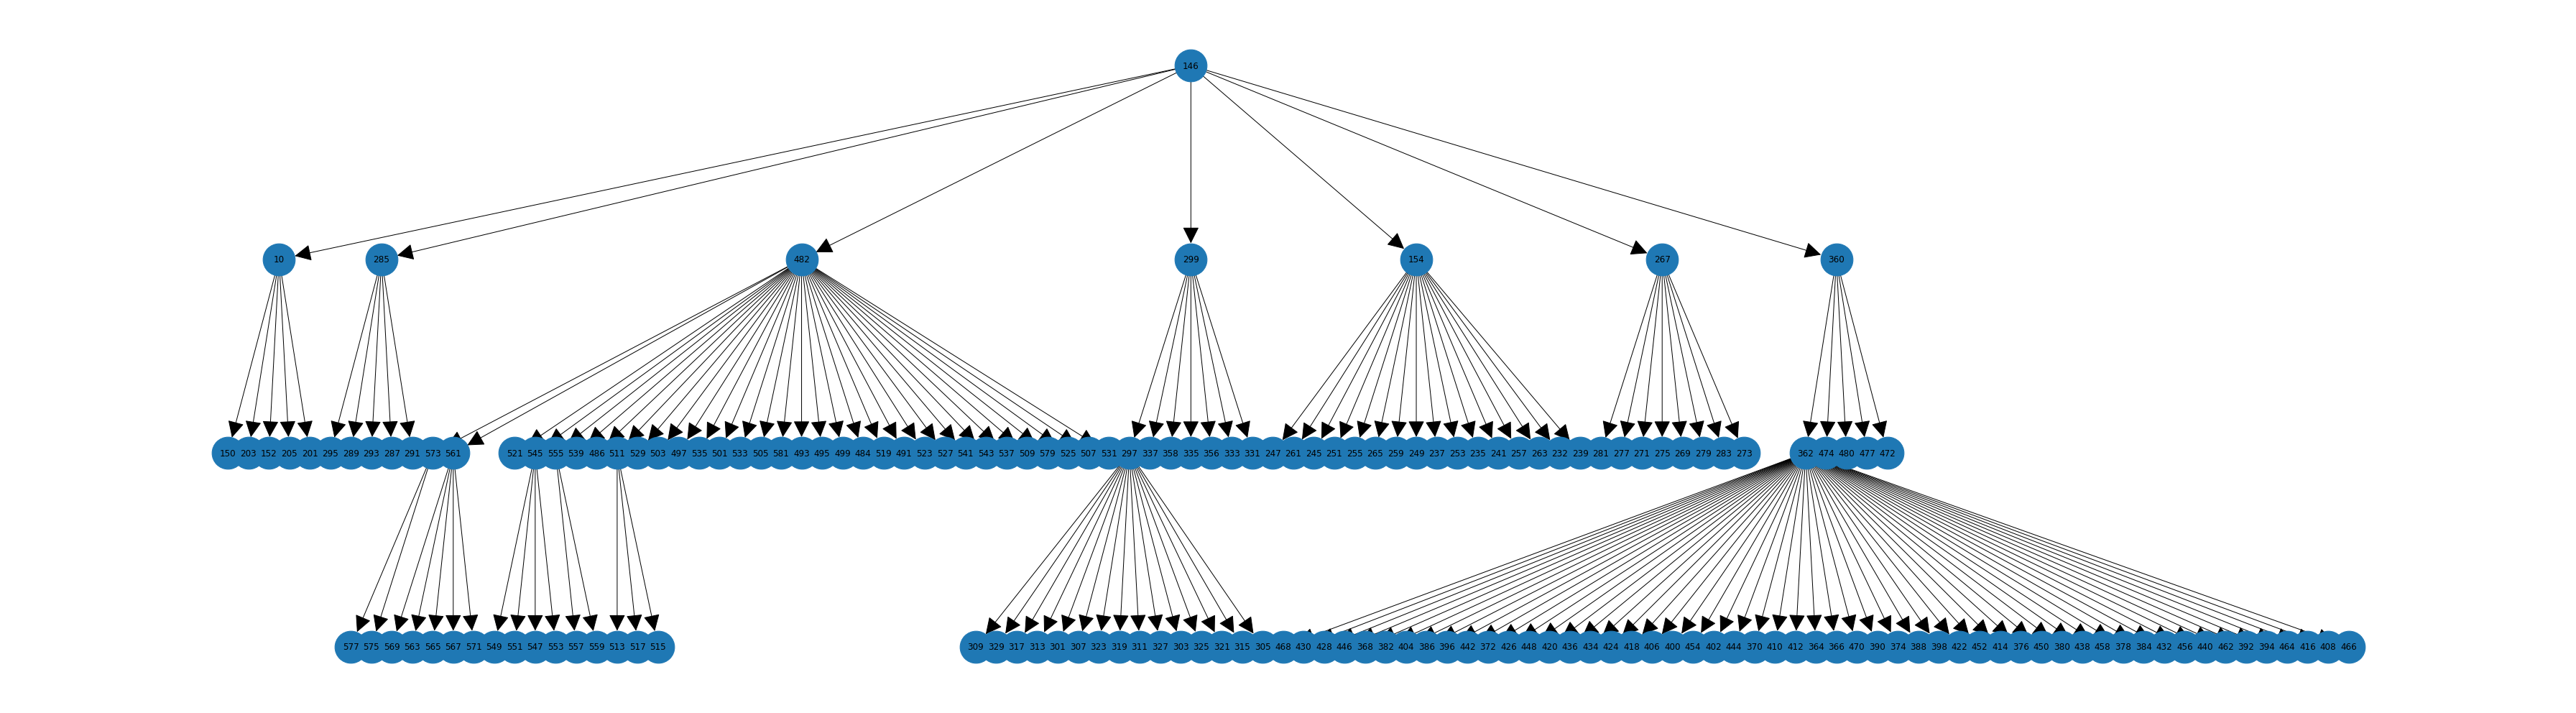

In [2]:
# plots TOC structure

from networkx.drawing.nx_pydot import pydot_layout
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1,figsize=(64,18))
nx.draw(
    DG,ax=ax,with_labels=True,
    node_size=2000,
    pos=pydot_layout(DG,root=TOP,prog='dot'),
    arrowsize=50,
)


In [6]:
#book=etree.Element('book')
import copy
eee=set()

def _add_append(a,b):
    if isinstance(b,list): a+=b
    else: a.append(b)

def _recurse(node,level=0):
    ch=chaps[node]
    childs=sorted(DG.successors(node))
    if node==PREFACE:
        #childs=[201,205,150,203,152]
        #assert set(childs)==set(DG.successors(node))
        childs=[205,150,203,152]
    # print(level*'  ',node,chaps[node].title)
    tag={0:'book',1:('preface' if node==PREFACE else 'part'),2:'chapter',3:'section'}[level]
    ret=etree.Element(tag)
    ret.append(title:=etree.Element('title'))
    title.text=ch.title
    if node==TOP: ch.content=None
    if ch.content is not None:
        for c in ch.content: ret.append(copy.deepcopy(c))
    for n in childs:
        ret.append(_recurse(n,level+1))
    return ret

#xmlNs='http://www.w3.org/XML/1998/namespace'
#xlinkNs='http://www.w3.org/1999/xlink'
#xlinkNs_='{'+xlinkNs+'}'
#nsmap={None:'http://docbook.org/ns/docbook','xlink':xlinkNs,'xml':xmlNs}

book=_recurse(TOP,level=0)
for e in book.iter(): eee.add(e.tag)
print(eee)
remove=[]
for e in book.iter():
    if e.tag in ('style','form','script','h1') or isinstance(e,lxml.etree._Comment):
        e.getparent().remove(e)
        continue
    if (cls:=e.get('class',None))=='Apple-converted-space':
        del e.attrib['class']
    e.tag={
        #'em':'emphasis','i':'emphasis',
        #'p':'para',
        #'span':'phrase',
        #'b':'emphasis',
        #'ul':'itemizedlist',
        #'li':'listitem',
        #'br':'phrase',
        'em':'emph',
        'h3':'emph',
        'h4':'emph',
        'i':'emph',
        'strong':'emph',
        'preface':'front',
        # 'b':'emph',
        #'part':'div1',
        #'chapter':'div2',
        #'section':'div3',
        'title':'head',
        }.get(e.tag,e.tag)
    if e.tag=='head':
        p=e.getparent()
        if p.tag=='part':
            p.tag='div'
            assert e.text.startswith('Part ')
            p.attrib['n']=e.text.split(':')[0][5:]
            e.text=e.text.split(':',1)[1][1:]
            p.attrib['type']='1-part'
        elif p.tag=='chapter':
            p.tag='div'
            p.attrib['type']='2-chapter'
            if e.text[0] in '123456789':
                p.attrib['n']=e.text.split('.')[0]
                e.text=e.text.split('.',1)[1][1:]
        elif p.tag=='section':
            # print(f'{e.text}')
            p.tag='div'
            p.attrib['type']='3-section'
    if e.tag=='phrase' and e.text is not None:
        pass
    if e.tag=='a':
        if len(e)>0 and e[0].tag=='img':
            # e[0].drop_tree()
            e.tag='graphic'
            e.attrib['url']='img/'+e.attrib['href'].split('/')[-1].replace('.gif','.png')
            remove.append(e[0])
        else:
            e.tag='ref'
            e.attrib['target']=e.attrib['href']
        del e.attrib['href']

for e in remove: e.getparent().remove(e)

for p in book.xpath('//p'):
    if p.tail=='\n': p.tail=None
        
for e in book.iter():
    if e.text is not None and '\xa0' in e.text: e.text=e.text.replace('\xa0',' ')
    if e.tail is not None and '\xa0' in e.tail: e.tail=e.tail.replace('\xa0',' ')

if 1:
    # remove front title (preface)
    book[1].remove(book[1][0])
    cred=book[1][0]
    assert cred[0].text=='Credits'
    for c in cred:
        if c.tag=='emph': c.tag='p'
    ded=book[1][2]
    assert ded[0].text=='Dedication'
    for c in ded:
        if c.tag=='emph':
            c.tag='p'
            if 'style' in c.attrib: del c.attrib['style']

if 1:
    # remove <br/>
    for br in book.xpath('//br'):
        assert br.text is None
        par,prev=br.getparent(),br.getprevious()
        if br.tail.startswith('\n'): br.tail=br.tail[1:]
        if prev is not None:
            #print(f'{br.getprevious().tag=} {br.tail[:50]=}')
            prev.tail+=' '+br.tail
        else:
            par.text+=' '+br.tail
            #print(f'{par.text[-50:]=} {par.tail=} {br.tail[:50]=}')
        br.getparent().remove(br)
if 1:
    # remove spurious <span>s
    for sp in book.xpath('//span'):
        par,prev=br.getparent(),br.getprevious()
        assert sp.text in ('\xa0','\xa0 ',' ','  ')
        # print(f'{sp.text=} {sp.tail=}')
        if sp.tail is None: pass
        elif sp.getparent().text is not None: sp.getparent().text+=sp.tail
        else: sp.getparent().text=sp.tail
        sp.getparent().remove(sp)

if 1:
    # fix tables
    for tab in book.xpath('//table'):
        # for a in 'cellspacing'
        assert len(tab)==1 and tab[0].tag=='tbody'
        tbody=tab[0]
        par=tab.getparent()
        par.insert(par.index(tab),tbody)
        par.remove(tab)
        tbody.tag='table'
    for tr in book.xpath('//tr'): tr.tag='row'
    for td in book.xpath('//td'):
        td.tag='cell'
        for a in ('valign','width'): 
            if a in td.attrib: del td.attrib[a]

    for tab in book.xpath('//table'):
        # merge PoI tables (broken accross pages)
        nx=tab.getnext()
        if nx is None or nx.tag!='table': continue
        assert len(tab[-1])==1 and tab[-1][0].text is None
        tab.remove(tab[-1])
        for row in nx:
            tab.append(row)
        nx.getparent().remove(nx)

if 1:
    # enumerations and itemizations
    for p in book.xpath('//p'):
        if p.text is None: continue
        if p.text.startswith('1)'): lst='1)'
        elif p.text.startswith('1.'): lst='1.'
        elif p.text.startswith('a.'): lst='a.'
        elif p.text.startswith('i.'): lst='i.'
        elif p.text.startswith('I.'): lst='I.'
        elif p.text.startswith('•'): lst='•'
        else: continue
        sep={'1)':')','1.':'.','a.':'.','i.':'.','I.':'.','•':' '}[lst]
        def _it(i,lst):
            if lst in ('1)','1.'): return [str(i) for i in range(100)][i]
            elif lst=='a.': return '_abcdefghijklmnopqrstuvwxyz'[i]
            elif lst=='i.': return [None,'i','ii','iii','iv','v','vi','vii','viii','ix'][i]
            elif lst=='I.': return [None,'I','II','III','IV','V'][i]
            elif lst=='•': return '•'
            assert False

        # print(p.text[:40])
        pp,i=[p],1
        while (p:=p.getnext()) is not None: # and nx.text.startswith(_it(i,lst)+' '):
            if p.text is None: break
            # print(f'  {_it(len(pp)+1,lst)=} {p.text[:10]=}')
            if not p.text.startswith(_it(len(pp)+1,lst)+sep): break
            i+=1
            pp.append(p)
        list=etree.Element('list')
        if lst=='•': list.attrib['rend']='bulleted'
        else:
            list.attrib['rend']='numbered'
            list.attrib['style']=lst
        par=pp[0].getparent()
        par.insert(par.index(pp[0]),list)
        for p in pp:
            p.tag='item'
            p.attrib['n'],p.text=p.text.split(sep,1)
            if lst=='•': del p.attrib['n']
            p.text=p.text.strip()
            list.append(p)
if 1:
    for ul in book.xpath('.//ul'):
        ul.tag='list'
        ul.attrib['rend']='bulleted'
        for li in ul:
            assert li.tag=='li'
            li.tag='item'
            
        
            
if 1:
    # descriptions (<p><b>...:</b> ...</p>)
    for p in book.xpath('.//p'):
        if p.getparent is None: continue # already removed
        def _it(p): return p is not None and len(p)==1 and p[0].tag=='b' and p.text is None and p.tail is None
        pp=[]
        while _it(p):
            pp.append(p)
            p=p.getnext()
        if len(pp)<10: continue

        list=etree.Element('list')
        list.attrib['type']='gloss'
        par=pp[0].getparent()
        par.insert(par.index(pp[0]),list)
        for p in pp:
            label=etree.Element('label')
            label.text=p[0].text
            item=etree.Element('item')
            item.text=p[0].tail
            list.append(label)
            list.append(item)
            par.remove(p)
    for b in book.xpath('.//b'): b.tag='emph'
            
for p in book.xpath('.//p'):
    if p.text and '\n' in p.text and p.tail is None: p.getparent().remove(p) # : print(p)

for ref in book.xpath('.//ref'):
    if 'rel' in ref.attrib: del ref.attrib['rel']

def mkSpan(t):
    sp=etree.Element('span')
    sp.text=t
    return sp


# remove all tails!!
for p in book.xpath('.//p|.//item'):
    if p.text is not None: 
        #p.insert(0,mkSpan('(('+p.text+'))'))
        p.insert(0,mkSpan(p.text))
        p.text=None
    if p.tail is not None:
        if p.tail.strip()!='':
            # assert False
            assert p.tag=='note'
            print(p.tail)
            p.getparent().insert(p.getparent().index(p)+1,mkSpan(p.tail))
        p.tail=None
for p in book.xpath('.//p|.//item'):
    assert p.text is None
    assert p.tail is None
    p.text=None
    for e in p:
        if len(e)>0: print(e)
        if e.tail is not None:
            par=e.getparent()
            # addnext would move the tail away; not what we want here
            # par.insert(par.index(e)+1,mkSpan('{{'+e.tail+'}}'))
            par.insert(par.index(e)+1,mkSpan(e.tail))
            e.tail=None

#print(f'{p.text[:50]=}')
if 1:
    import re
    for e in book.xpath('.//span'):
        assert e.text is not None
        if m:=re.match('^(.*)\[(.{30,})\](.*)',e.text):
            assert e.tail is None
            note=etree.Element('note')
            note.attrib['place']='foot'
            ns=etree.Element('span')
            ns.text=m[2]
            note.append(ns)
            e.text=m[1]
            e.addnext(mkSpan(m[3]))
            # e.append(note) # addnext(note)
            e.addnext(note)



for head in book.xpath('.//head'):
    div=head.getparent()
    if div.tag=='book': continue
    assert div.tag=='div'
    div.attrib['name']=head.text

for em in book.xpath('.//emph'):
#    # print(em.getnext())
    nx=em
    while (nx:=em.getnext()) is not None and nx.tag=='emph':
        em.text+=nx.text
        em.getparent().remove(nx)
#        print(em.text)

# change ref inside emph to emph inside ref
for em in book.xpath('.//emph'):
    if len(em)!=1 or em[0].tag!='ref': continue
    em.tag='ref'
    em.attrib['target']=em[0].attrib['target']
    del em[0].attrib['target']
    em[0].tag='emph'

for span in book.findall('.//span'):
    if '_' not in span.text: continue
    span.text=span.text.replace('_','…')
        
        
pI=book[2]
assert pI.tag=='div' and pI.attrib['n']=='I'
body=etree.Element('body')
book.insert(2,body)
for e in book[3:]: body.append(e)
back=etree.Element('back')
book.append(back)
back.append(body[-1][-2])
back.append(body[-1][-1])
book.tag='text'
assert book[0].tag=='head' and book[0].text=='MCTB2'
book.remove(book[0])

TEI=etree.Element('TEI')
TEI.append(book)

teiHeader=etree.parse('teiHeader.xml').getroot()
TEI.insert(0,teiHeader)

#eee=set()
#for e in book.iter(): eee.add(e.tag)
#print(eee)

etree.indent(TEI,'  ')
open('mctb.tei','w').write(etree.tostring(TEI,encoding='unicode',pretty_print=True))

{'h3', 'tbody', 'h4', 'li', 'a', 'p', 'preface', 'title', 'br', 'part', 'img', 'table', 'i', 'chapter', 'b', 'section', 'strong', 'tr', 'book', 'em', 'ul', 'h1', 'td', 'span'}
<Element ref at 0x7fbfdebc2cc0>
<Element ref at 0x7fbfdebc2cc0>
<Element ref at 0x7fbfdebc2cc0>
<Element ref at 0x7fbfdeb93f80>
<Element ref at 0x7fbfe17cbfc0>
<Element ref at 0x7fbfe17cbfc0>
<Element emph at 0x7fbfdebc2cc0>
<Element emph at 0x7fbfdeb93f80>
<Element ref at 0x7fbfdeb93f80>
<Element ref at 0x7fbfdebc39c0>
<Element emph at 0x7fbfdebc3480>


2094643

In [ ]:
tei=etree.parse('mctb.tei').getroot()
for e in tei.iter():
    if e.tail is not None and e.tail.strip()!='': print(f'{e.sourceline}')

In [ ]:
chaps[201].path

In [216]:
book[2].tag

'div'